# Autoencoders : suite

On va revenir sur quelques points qui m'intriguent suite au premier test sur les autoencoders.
Les résultats seront différents puisque le dataset a évolué.

## Modification des prédictions

J'ai fait l'erreur de laisser mon user dans le training set (ou le test set), il est possible que les prédictions soient donc biaisées. On recommence rapidement mais en supprimant mon user du jeu de données.

In [1]:
import pickle
import bz2
sfile = bz2.BZ2File('../datasets/results_anonym.dmp.gz', 'r')
datas = pickle.load(sfile)

In [2]:
import numpy as np


def formatData(data, users_to_delete = ['hfred1982']):
    """Transform the dictionnary data into numpy array for machine learning
    
    """
    users = []
    for item in data.values():
        for note in item.keys():
            if "note_" in note and note != 'note_globale' and item[note] is not None:
                user = note.replace('note_','')
                if user not in users and user not in users_to_delete:
                    users.append(user)
                
    films = list(data.keys())

    nb_movies = len(films)
    nb_users = len(users)


    films_id_to_num = {}
    users_name_to_num = {}

    for i in range(0,len(films)):
        films_id_to_num[films[i]] = i

    for i in range(0,len(users)):
        users_name_to_num[users[i]] = i

    X = np.zeros([nb_users, nb_movies])


    for item in data.values():
        for note in item.keys():
            if "note_" in note and note != 'note_globale' and item[note] is not None:
                user = note.replace('note_','')
                if user not in users_to_delete:
                    num_line = users_name_to_num[user]
                    num_col = films_id_to_num[item['id']]
                    X[num_line,num_col] = item[note]
    
    return X, films, users

X, films, users = formatData(datas)

In [3]:
X.shape

(833, 86824)

OK, on nettoie un peu tout ça :

In [4]:
def cleanData(X, films, min_num_notes = 150):
    
    # Count number of film to keep (for performance better than rebuild the array)
    nb_users = len(X[:,0])
    nb_movies = len(X[0,:])
    
    nb_movies_to_keep = 0
    for i in range(nb_movies):
        if np.size(np.nonzero(X[:,i])) > min_num_notes:
            nb_movies_to_keep += 1

    X_filtered = np.zeros([nb_users, nb_movies_to_keep])
    
    
    # Filling the array with data
    films_to_keep = []
    current=0

    for i in range(nb_movies):
        if np.size(np.nonzero(X[:,i])) > min_num_notes:
            X_filtered[:,current] = X[:,i]
            current += 1
            films_to_keep.append(films[i])
    
    X = X_filtered
    films = films_to_keep
    
    return X, films

X, films =  cleanData(X, films, 250)

In [5]:
X.shape

(833, 1288)

In [6]:
def buildReverseList(liste):
    new_liste = {}
    for i in range(len(liste)):
        new_liste[liste[i]] = i
    return new_liste

films_id_to_num = buildReverseList(films)
users_name_to_num = buildReverseList(users)

nb_movies = len(films)
nb_users = len(users)

On recréé, l'autoencoder exactement de la même façon.

In [8]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

# Creating the architecture of the Neural Network
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)

# Converting the data into Torch tensors
training_set = torch.FloatTensor(X_train)
test_set = torch.FloatTensor(X_test)

On l'entraine :

In [9]:
# Training the SAE
nb_users = X_train[:,0].size
nb_epoch = 50
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data[0]*mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: 1.764271800434479
epoch: 2 loss: 1.5153955544787296
epoch: 3 loss: 1.515005433339649
epoch: 4 loss: 1.5150035267982718
epoch: 5 loss: 1.5151045571098927
epoch: 6 loss: 1.5153093616350164
epoch: 7 loss: 1.5148347199394052
epoch: 8 loss: 1.515166225019856
epoch: 9 loss: 1.5152971172452752
epoch: 10 loss: 1.5152830846387457
epoch: 11 loss: 1.5152473039418746
epoch: 12 loss: 1.5151214219641018
epoch: 13 loss: 1.5145224693720987
epoch: 14 loss: 1.5147904552193383
epoch: 15 loss: 1.5148852610066466
epoch: 16 loss: 1.5148029218573589
epoch: 17 loss: 1.514524887290377
epoch: 18 loss: 1.5134200722330775
epoch: 19 loss: 1.5130232721464334
epoch: 20 loss: 1.513680513128327
epoch: 21 loss: 1.5130545048344917
epoch: 22 loss: 1.5147215461671832
epoch: 23 loss: 1.514323058269084
epoch: 24 loss: 1.5140223942224003
epoch: 25 loss: 1.5152020990661186
epoch: 26 loss: 1.5151834347169728
epoch: 27 loss: 1.5155094541399308
epoch: 28 loss: 1.5160041184069313
epoch: 29 loss: 1.5157934035461234


OK, sensiblement la même chose que la dernière fois. Et on compare avec notre test set :

In [10]:
# Testing the SAE
nb_users = X_test[:,0].size
test_loss = 0
s = 0.
for id_user in range(nb_users):
    input = Variable(test_set[id_user]).unsqueeze(0)
    target = Variable(test_set[id_user])
    if torch.sum(target.data > 0) > 0:
        output = sae(input)
        target.require_grad = False
        output[target == 0] = 0
        loss = criterion(output, target)
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data[0]*mean_corrector)
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: 1.574583717003803


Ah l'erreur est un peu plus importante cette fois. Rien de traumatisant cependant.

On peut maintenant faire une prédiction pour mon utilisateur. Pour cela il faut recréer un vecteur de notes uniquement pour lui :

In [35]:
my_notes = []

for i in range(nb_movies):
    if 'note_hfred1982' not in datas[films[i]].keys():
        my_notes.append(0)
    else :
        my_notes.append(datas[films[i]]['note_hfred1982'])
    

On peut refaire des prédictions et calculer l'erreur globale :

In [15]:
# Using the SAE
all_set = torch.FloatTensor(X)
input = Variable(torch.FloatTensor(my_notes)).unsqueeze(0)
output = sae(input)

In [16]:
error = 0
error_note_globale = 0
nb_films = 0
for i in range(nb_movies):
    if my_notes[i] != 0:
        error += (my_notes[i] - output.data[0][i])**2
        error_note_globale += (my_notes[i] - datas[films[i]]['note_globale'])**2
        nb_films +=1 
        
print("Erreur de l'autoencoder : "+str(np.sqrt(error/nb_films)))
print("Erreur de la note globale : "+str(np.sqrt(error_note_globale/nb_films)))

Erreur de l'autoencoder : 1.4058740376569128
Erreur de la note globale : 1.4440281823095926


Voilà, au final l'erreur reste sensiblement la même mais au moins je suis sûr que l'entrainement n'a pas influencé mes prédictions.

## Classification des films

A la fin du test précédent, j'essayais de voir si certains films pouvaient être regroupés en étudiants les poids qui leur est attribué sur chaque des noeuds de l'autoencoder. Mais c'est un problème de clustering... D'où l'idée d'appliquer un algo de clustering sur les poids des noeuds. Pas sûr que ça mène quelque part, mais ça se tente.

In [18]:
X = np.array(sae.fc1.weight.transpose(0,1).data)
X.shape

(1288, 20)

On commence par normaliser les données :

In [19]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

On va utiliser l'algorithme K-moyennes et la "elbow method" pour essayer de trouver un nombre de cluster

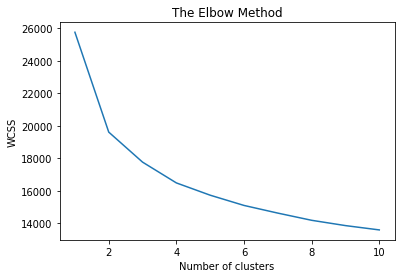

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Disons donc que l'on va tenter avec 4 clusters pour commencer.

In [25]:
# Fitting K-Means to the dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X)

Et au final, on affiche tous les films qui sont dans le même cluster en essayant d'en trouver un intéressant.

In [28]:
current_cluster = 1
for i in range(nb_movies):
    if y_kmeans[i] == current_cluster:
        print(datas[films[i]]['title'] + " - "+ datas[films[i]]['genres'])

Green Book : Sur les routes du sud - Drame,biopic,road movie
Dernier train pour Busan - Action,Épouvante-horreur,thriller
The Big Short : Le Casse du siècle - Comédie dramatique
Harry Potter et le Prisonnier d'Azkaban - Aventure,fantastique
Wind River - Thriller,drame,policier
Parasite - Drame,thriller
John Wick 2 - Action,thriller,policier
John Wick - Action,thriller,policier
Les Indestructibles 2 - Animation,action,aventure
American Bluff - Comédie,drame,historique
First Man, le premier homme sur la Lune - Biopic,drame
Gone Girl - Drame,thriller
Ready Player One - Science-fiction,action,aventure
La La Land - Comédie musicale,comédie dramatique,romance
La Forme de l'eau - Drame,fantastique,romance
Happiness Therapy - Comédie dramatique
Jupiter : Le Destin de l'univers - Action,aventure,science-fiction
Invictus - Biopic,drame,historique,sport
Pentagon Papers - Biopic,drame,historique,thriller
Tu ne tueras point - Biopic,drame,historique,guerre
Glass - Thriller,fantastique
Blade Runner 

Evidemment avec 4 clusters pour plus de 1200 films, on retrouve tout et n'importe quoi, mais il est intéressant de constater par exemple que tous les Harry Potter se retrouve dans ce cluster. Prenons le problème à l'envers : essayons avec un plus grand nombre de cluster et regardons où se retrouvent les Harry Potter :

In [29]:
# Fitting K-Means to the dataset
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 30, init = 'k-means++', random_state = 0)
y_kmeans = kmeans.fit_predict(X)

In [31]:
for film_id in [447682, 435375, 477607, 459448, 465898, 405455, 482419, 453930]:
    print(datas[film_id]['title'] + " : " + str(y_kmeans[films_id_to_num[film_id]]))

Harry Potter à l'école des sorciers : 7
Harry Potter et la Chambre des secrets : 14
Harry Potter et le Prisonnier d'Azkaban : 14
Harry Potter et la Coupe de feu : 7
Harry Potter et l'Ordre du phénix : 14
Harry Potter et le Prince de sang-mêlé : 1
Harry Potter et les Reliques de la Mort : 1ère partie : 14
Harry Potter et les Reliques de la Mort : 2ème partie : 14


Sur 30 clusters possibles, 5 films se retrouvent dans le même ! Très intéressant, je m'attendais honnêtement à moins.